### Analytic Predictions for Binary Evolution

Here we are checking that the N-body simulations are giving valid results by creating analytic predictions to compare them to. 

In [18]:
# Program to calculate binary evolution from constant time lag formalism

import numpy as np
import rebound as rb
import reboundx as rx
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from scipy.integrate import odeint
from scipy.integrate import quad
import scipy
from scipy import integrate

In [ ]:
""" All functions [functions N(e), Omega(e), Omegae(e), Na(e), and Ne(e)] as defined in Leconte et al. (2010), A&A, doi:10.1051/0004-6361/201014337 """

In [29]:
def N(e):
    num = 1. + 15./2.*e**2. + 45./8.*e**4. + 5./16.*e**6.
    den = (1.-e**2.)**6.
    return num/den

In [30]:
def Na(e):
    num = 1. + 31./2.*e**2. + 255./8.*e**4. + 185./16.*e**6. + 25./64.*e**8.
    den = (1.-e**2.)**(15./2.)
    return num/den

In [31]:
def Omegae(e):
    num = 1. + 3./2.*e**2. + 1./8.*e**4.
    den = (1.-e**2.)**5.
    return num/den

In [32]:
def Ne(e):
    num = 1. + 15./4.*e**2. + 15./8.*e**4. + 5./64.*e**6.
    den = (1.-e**2.)**(13./2.)
    return num/den

In [33]:
def Omega(e):
    num = 1. + 3.*e**2. + 3./8.*e**4.
    den = (1.-e**2.)**(9./2.)
    return num/den

In [34]:
def Fe(e):
    om_eq = N(e)/Omega(e)  # This is the "pseudo-synchronous" rotation
    return Omegae(e)*om_eq - 18./11.*Ne(e)

In [35]:
def Fa(e):
    om_eq = N(e)/Omega(e)  # This is the "pseudo-synchronous" rotation
    return 4./11.*(N(e)*om_eq - Na(e))

Parameters: 
orb = (a[0],e[0]) initial orbital elements of binary
time is time array you integrate simulation over
mu is binary mass ratio M_2/M_1 *not* reduced mass 

In [36]:
MU = 0.5
M1 = M2 = 1
G = 1 # gravitational constant is now 1 to reflect REBOUND units for the odeint (#G = 6.67E-11)
R_star = 0.1*(1-0.5)**(1/3)

In [20]:
def sim_params(archive, extras, tau):
    """ Grabbing the simulation parameters from the simulation archive"""
    sim = None
    sim = rx.SimulationArchive(archive, rebxfilename=extras)
    e = sim[0][0].particles[1].e
    a = sim[0][0].particles[1].a
    k_2 = sim[0][0].particles[0].params["tctl_k1"]
    # tau must be manually input
    G = 1 # gravitational constant is now 1 to reflect REBOUND units for the odeint (#G = 6.67E-11)
    R_star = 0.1*(1-0.5)**(1/3)
    
    NB = sim[0][0].particles[1].n
    K0 = ((3/2)*(NB**2)*k_2*tau)*((G*(M1**2))/R_star)*((M1/M2)**2)*(R_star/a)**6
    
    return NB, K0, archive, extras, sim

In [ ]:
# the sim calls below need to look into the directory instead of uploading individuals to jupyter 

In [21]:
sim1 = sim_params("eb0.525_ap4.500_Np15.0_tup25.0_Q10000.0_tau0.0030.bin","xarchive.bin", 0.0030)

In [22]:
sim2 = sim_params("eb0.058_ap5.000_Np15.0_tup25.0_Q100000.0_tau0.0003.bin","xarchive.bin",0.0003)

In [23]:
sim3 = sim_params("eb0.233_ap1.167_Np15.0_tup25.0_Q10000.0_tau0.0030.bin","xarchive.bin",0.0030)

In [38]:
sim4 = sim_params("COPE_SUNNY_FINE_TUP_50_eb0.500_ap4.347_Np15.0_tup50.0_Q100.0_tau0.3030.bin",
           "xarchive_SUNNY_FINE_TUP_50.bin", 0.3030)

In [39]:
sim5 = sim_params("COPE_SUNNY_FINE_LONG_eb0.500_ap4.347_Np15.0_tup50.0_Q100.0_tau0.3030.bin",
                  "xarchive_SUNNY_FINE_LONG.bin",0.3030)

In [24]:
# editing GOOD MAYBE
def TideEq(orbit,time,MU,NB,K0):
    
    """ Takes the secondary binaries semi-major axis and eccentricity parameters at the same point during
    a simulation along with its time
    Returns the differential equations for the secondary binaries evolution of both semi-major axis and
    eccentricity.
    """
    ab = orbit[0]
    eb = orbit[1]
    
    ab0 = ab
    k = K0*(ab0/ab)**9
    
    # evolution of binary semi-major axis and eccentricity assuming a psudo-synchronous rotation
    dedt = ((11*eb*ab*k)/(G*M1*M2))*(Fe(eb)) # Differential equation for eccentricity
    dadt = ((11*k*ab**2)/(G*M1*M2))*(Fa(eb)) # Differential equation for semi-major axis # not 4 as the coefficient?
    
    return [dadt,dedt] # Returns differential equation for a and e

In [25]:
# EDITING GOOD
def evolution(simulation):
    """
    Initializing empty list to collect semi-major axis and eccentricity values as they evolve through the
    analytic integration.
    Input:
    simulation: name with which the simulation was loaded with
    nb: mean motion
    k: tidal love number
    
    Output:
    evolve: 2D list of ab and eb integrated times in the form ([eb_ev],[ab_ev])
    """
    NB = simulation[0]
    K0 = simulation[1]
    archive = simulation[4]
    
    ab_ev = []
    eb_ev = []
    
    orb = [] # orb = (a[0],e[0]) are the initial orbital elements of the secondary binary
    eb = archive[0][0].particles[1].e
    ab = archive[0][0].particles[1].a
    orb.append((ab,eb))
    # orb = (a[0],e[0]) are the initial orbital elements of the secondary binary
    
    last_snap = len(archive) - 1
    t_end = archive[last_snap][0].t
    tb = np.linspace(0.,t_end)
    orbb = (orb[0][0],orb[0][1])
    solb = odeint(TideEq, orbb, tb, args=(MU,NB,K0))
    
    ab_ev = solb[:,0]
    eb_ev = solb[:,1]
    evolve = (tb, ab_ev, eb_ev)
    
    return evolve # time, a evolution, e evolution

In [26]:
# EDITING GOOD
def binary_semi(simulation):
    """ Pulling data from the called upon simulation archive using REBOUND and REBOUNDx to collect evolution of the
    secondary binaries semi-major axis.
    Returns two arrays, one of the  evolving semi-major axis values and the other with cooresponding simulation times."""
    sim_arc = simulation[4] 
    
    x_arr = []
    y_arr = []
    
    for snap in range(len(sim_arc)): 
        base = sim_arc[snap][0].particles[1]
        orb_element = base.a
        time = (sim_arc[snap][0].t)
        
        y_arr.append(orb_element)
        x_arr.append(time)
        
    return x_arr, y_arr

In [27]:
# EDITING GOOD
def binary_ecc(simulation):
    """ Pulling data from the called upon simulation archive using REBOUND and REBOUNDx to collect evolution of the
    secondary binaries eccentricity.
    Returns two arrays, one of the  evolving eccentricity values and the other with cooresponding simulation times."""
    sim_arc = simulation[4]
    
    x_arr = [] # eccentricity
    y_arr = [] # time
    
    for snap in range(len(sim_arc)): 
        base = sim_arc[snap][0].particles[1]
        orb_element = base.e
        time = (sim_arc[snap][0].t)
        
        y_arr.append(orb_element)
        x_arr.append(time)

    return x_arr, y_arr

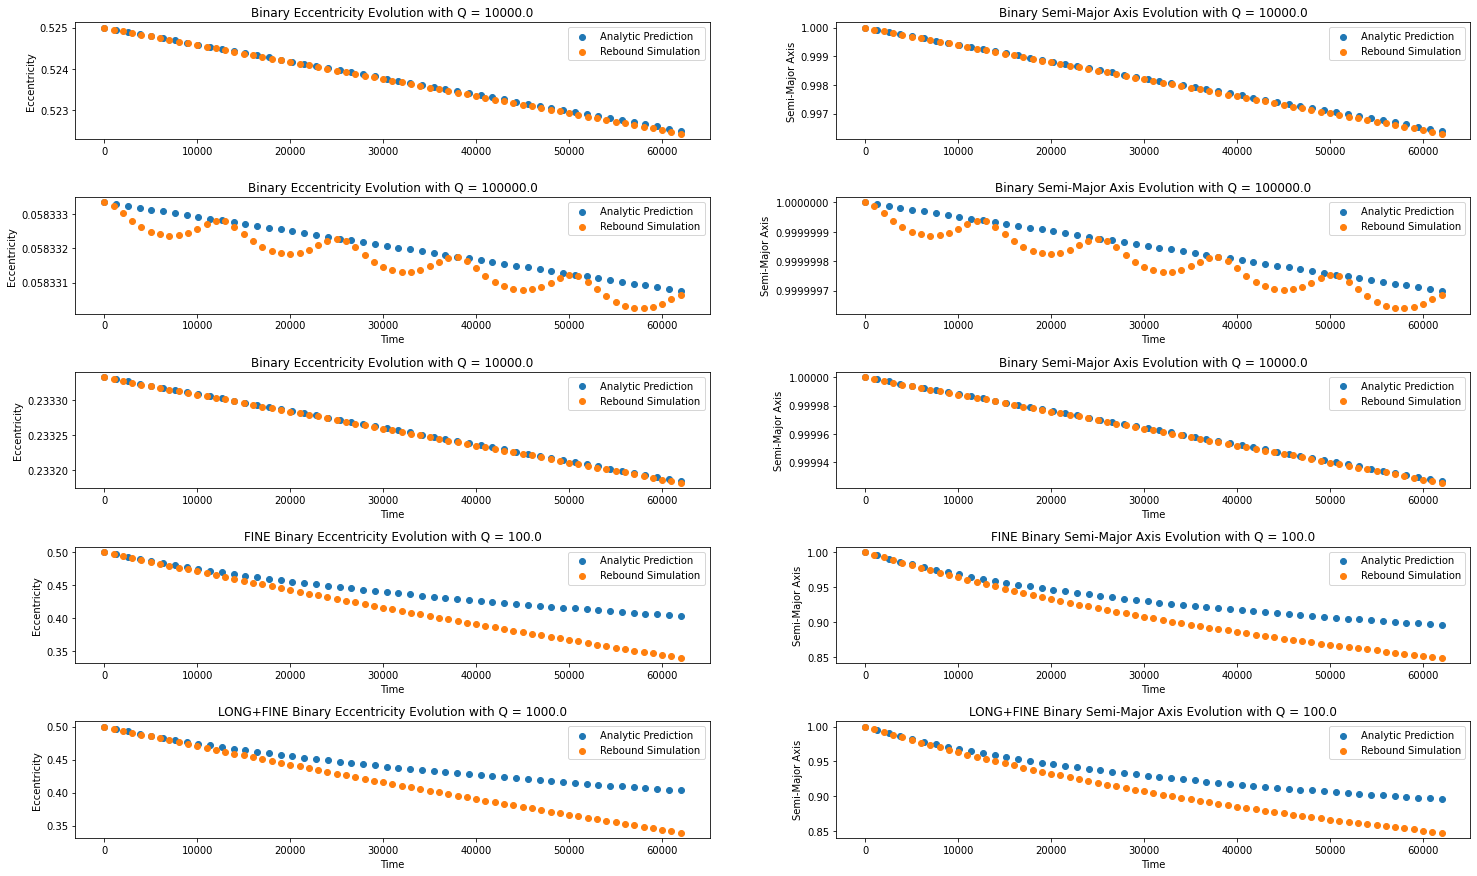

In [40]:
""" Overplotting the evolution of the secondary binaries semi-major axis and eccentricity values as taken from the
simulation and the analytic integration for comparison"""

fig, axs = plt.subplots(5,2,figsize=(25,15)) #sharex =True, figsize=(25,15))

ecc = binary_ecc(sim1)
semi = binary_semi(sim1)
p1 = evolution(sim1)

axs[0][0].scatter(p1[0], p1[2], label="Analytic Prediction")
axs[0][0].scatter(ecc[0], ecc[1], label="Rebound Simulation")
axs[0][0].set_ylabel("Eccentricity")
axs[0][0].set_title(r"Binary Eccentricity Evolution with Q = 10000.0")

axs[0][1].scatter(p1[0], p1[1], label="Analytic Prediction")
axs[0][1].scatter(semi[0], semi[1], label="Rebound Simulation")
axs[0][1].set_ylabel("Semi-Major Axis")
axs[0][1].set_title("Binary Semi-Major Axis Evolution with Q = 10000.0")

#plt.savefig("overplot.png") # rename based on sim snapshot and as re-evaluated 

ecc2 = binary_ecc(sim2)
semi2 = binary_semi(sim2)
p2 = evolution(sim2)

axs[1][0].scatter(p2[0], p2[2], label="Analytic Prediction")
axs[1][0].scatter(ecc2[0], ecc2[1], label="Rebound Simulation")
axs[1][0].set_xlabel("Time")
axs[1][0].set_ylabel("Eccentricity")
axs[1][0].ticklabel_format(useOffset=False)
axs[1][0].set_title("Binary Eccentricity Evolution with Q = 100000.0")

axs[1][1].scatter(p2[0], p2[1], label="Analytic Prediction")
axs[1][1].scatter(semi2[0], semi2[1], label="Rebound Simulation")
axs[1][1].set_xlabel("Time")
axs[1][1].set_ylabel("Semi-Major Axis")
axs[1][1].ticklabel_format(useOffset=False)
axs[1][1].set_title("Binary Semi-Major Axis Evolution with Q = 100000.0")

ecc3 = binary_ecc(sim3)
semi3 = binary_semi(sim3)
p3 = evolution(sim3)

axs[2][0].scatter(p3[0], p3[2], label="Analytic Prediction")
axs[2][0].scatter(ecc3[0], ecc3[1], label="Rebound Simulation")
axs[2][0].set_xlabel("Time")
axs[2][0].set_ylabel("Eccentricity")
axs[2][0].ticklabel_format(useOffset=False)
axs[2][0].set_title("Binary Eccentricity Evolution with Q = 10000.0")

axs[2][1].scatter(p3[0], p3[1], label="Analytic Prediction")
axs[2][1].scatter(semi3[0], semi3[1], label="Rebound Simulation")
axs[2][1].set_xlabel("Time")
axs[2][1].set_ylabel("Semi-Major Axis")
axs[2][1].ticklabel_format(useOffset=False)
axs[2][1].set_title("Binary Semi-Major Axis Evolution with Q = 10000.0")

ecc4 = binary_ecc(sim4)
semi4 = binary_semi(sim4)
p4 = evolution(sim4)

axs[3][0].scatter(p4[0], p4[2], label="Analytic Prediction")
axs[3][0].scatter(ecc4[0], ecc4[1], label="Rebound Simulation")
axs[3][0].set_xlabel("Time")
axs[3][0].set_ylabel("Eccentricity")
axs[3][0].ticklabel_format(useOffset=False)
axs[3][0].set_title("FINE Binary Eccentricity Evolution with Q = 100.0")

axs[3][1].scatter(p4[0], p4[1], label="Analytic Prediction")
axs[3][1].scatter(semi4[0], semi4[1], label="Rebound Simulation")
axs[3][1].set_xlabel("Time")
axs[3][1].set_ylabel("Semi-Major Axis")
axs[3][1].ticklabel_format(useOffset=False)
axs[3][1].set_title("FINE Binary Semi-Major Axis Evolution with Q = 100.0")

ecc5 = binary_ecc(sim5)
semi5 = binary_semi(sim5)
p5 = evolution(sim5)

axs[4][0].scatter(p5[0], p5[2], label="Analytic Prediction")
axs[4][0].scatter(ecc5[0], ecc5[1], label="Rebound Simulation")
axs[4][0].set_xlabel("Time")
axs[4][0].set_ylabel("Eccentricity")
axs[4][0].ticklabel_format(useOffset=False)
axs[4][0].set_title("LONG+FINE Binary Eccentricity Evolution with Q = 100.0")

axs[4][1].scatter(p5[0], p5[1], label="Analytic Prediction")
axs[4][1].scatter(semi5[0], semi5[1], label="Rebound Simulation")
axs[4][1].set_xlabel("Time")
axs[4][1].set_ylabel("Semi-Major Axis")
axs[4][1].ticklabel_format(useOffset=False)
axs[4][1].set_title("LONG+FINE Binary Semi-Major Axis Evolution with Q = 100.0")


axs[0][0].legend()
axs[0][1].legend()

axs[1][1].legend()
axs[1][0].legend()

axs[2][0].legend()
axs[2][1].legend()

axs[3][0].legend()
axs[3][1].legend()

axs[4][0].legend()
axs[4][1].legend()

plt.subplots_adjust(hspace=0.5) # wspace, 

Text(0.5, 1.0, 'LONG+FINE Binary Semi-Major Axis Evolution with Q = 100.0')

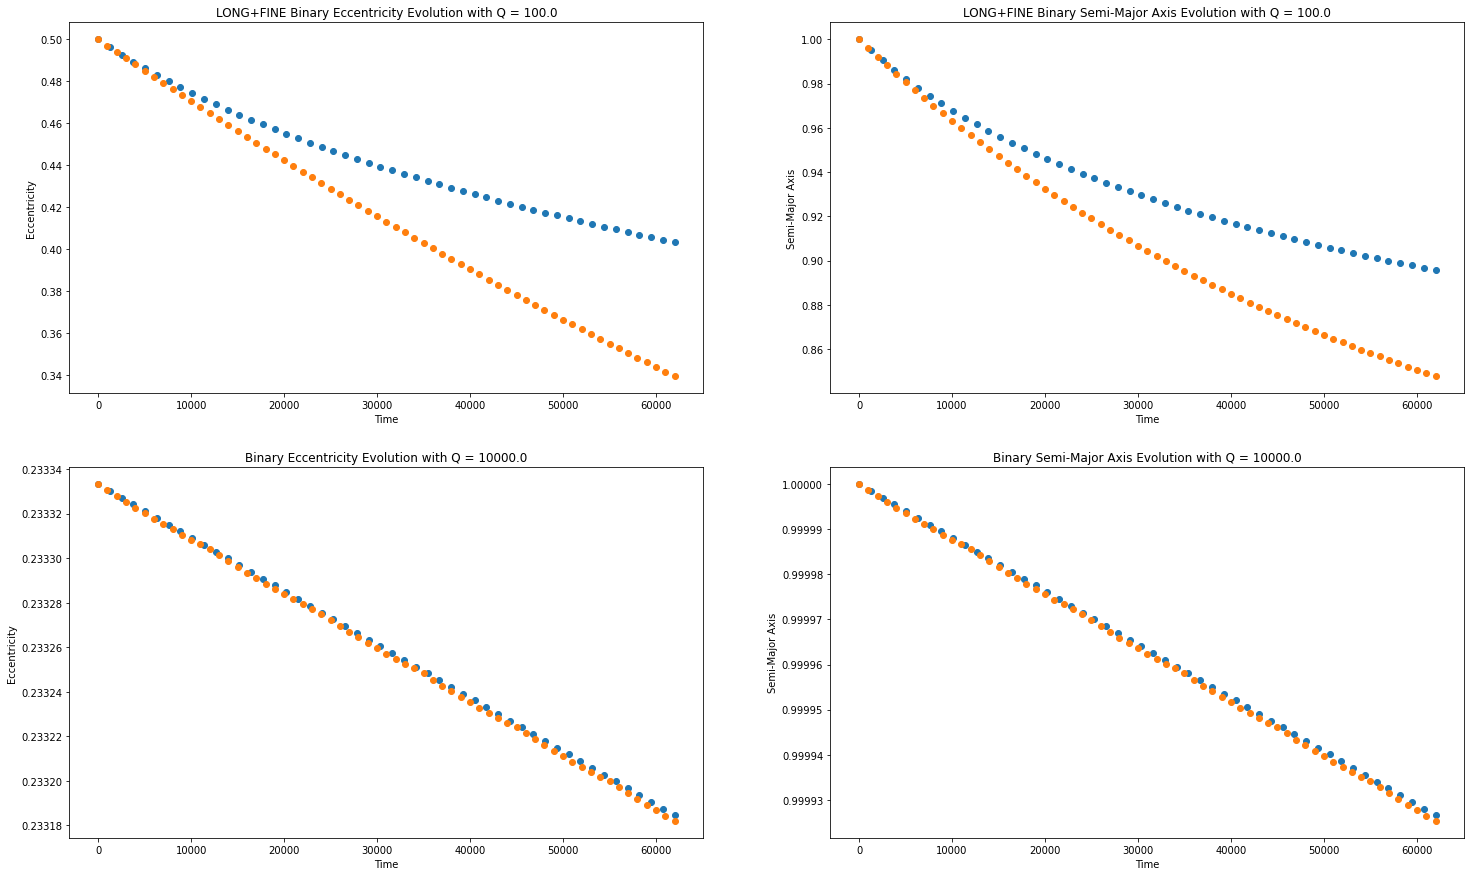

In [44]:
fig, axs = plt.subplots(2,2,figsize=(25,15))


axs[1][0].scatter(p3[0], p3[2], label="Analytic Prediction")
axs[1][0].scatter(ecc3[0], ecc3[1], label="Rebound Simulation")
axs[1][0].set_xlabel("Time")
axs[1][0].set_ylabel("Eccentricity")
axs[1][0].ticklabel_format(useOffset=False)
axs[1][0].set_title("Binary Eccentricity Evolution with Q = 10000.0")

axs[1][1].scatter(p3[0], p3[1], label="Analytic Prediction")
axs[1][1].scatter(semi3[0], semi3[1], label="Rebound Simulation")
axs[1][1].set_xlabel("Time")
axs[1][1].set_ylabel("Semi-Major Axis")
axs[1][1].ticklabel_format(useOffset=False)
axs[1][1].set_title("Binary Semi-Major Axis Evolution with Q = 10000.0")



axs[0][0].scatter(p5[0], p5[2], label="Analytic Prediction")
axs[0][0].scatter(ecc5[0], ecc5[1], label="Rebound Simulation")
axs[0][0].set_xlabel("Time")
axs[0][0].set_ylabel("Eccentricity")
axs[0][0].ticklabel_format(useOffset=False)
axs[0][0].set_title("LONG+FINE Binary Eccentricity Evolution with Q = 100.0")

axs[0][1].scatter(p5[0], p5[1], label="Analytic Prediction")
axs[0][1].scatter(semi5[0], semi5[1], label="Rebound Simulation")
axs[0][1].set_xlabel("Time")
axs[0][1].set_ylabel("Semi-Major Axis")
axs[0][1].ticklabel_format(useOffset=False)
axs[0][1].set_title("LONG+FINE Binary Semi-Major Axis Evolution with Q = 100.0")

The analytic integration compared with the simulation data shows that the simulations are correctly allowing for the binaries to circularize and migrate.

In [ ]:
""" Collect Final Binary Eccentricities for all Simulations """